In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv(r"C:\Users\Dell\gitproject\Energy_Demand_Forecasting\data\processed\Energy Consumption Cleaned.csv", parse_dates=['Date'])

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.head()

,States,Regions,latitude,longitude,Date,Energy Consumption
0,Punjab,NR,31.519974,75.980003,2019-02-01,119.9
1,Haryana,NR,28.450006,77.019991,2019-02-01,130.3
2,Rajasthan,NR,26.449999,74.639981,2019-02-01,234.1
3,Delhi,NR,28.669993,77.230004,2019-02-01,85.8
4,UP,NR,27.599981,78.050006,2019-02-01,313.9


In [9]:
print("Number of duplicates:", df.duplicated(subset=['Date', 'States']).sum())
df_agg = df.groupby(['Date', 'States'], as_index=False)['Energy Consumption'].mean()


Number of duplicates: 153


In [11]:
df_wide = df_agg.pivot(index='Date', columns='States', values='Energy Consumption')


In [13]:
print(df_wide.head())


States      Andhra Pradesh  Arunachal Pradesh  Assam  Bihar  Chandigarh  \
Date                                                                      
2019-01-07           164.3                2.3   34.2  104.7         4.8   
2019-01-08           197.0                2.4   32.7  106.4         5.5   
2019-01-09           153.8                2.3   36.1   96.1         5.4   
2019-01-10           155.4                1.9   30.2   88.1         3.9   
2019-01-11           154.9                1.5   19.2   82.8         2.4   

States      Chhattisgarh   DNH  Delhi   Goa  Gujarat  ...  Pondy  Punjab  \
Date                                                  ...                  
2019-01-07          94.5  18.9  103.8  11.7    300.2  ...    7.5   163.9   
2019-01-08          87.9  17.8   99.3  11.5    316.1  ...    9.2   206.1   
2019-01-09          95.8  18.4  113.9  11.5    320.2  ...    7.4   224.0   
2019-01-10          78.2  18.2   80.7  10.3    362.1  ...    6.9   118.9   
2019-01-11        

In [15]:
# Function to create lag features for a single time series
def create_lag_features(series, n_lags=7):
    """
    Create lag features from a time series for supervised learning.
    series: 1D pandas Series (time series values)
    n_lags: number of lag days
    
    Returns a DataFrame with lag features and target variable
    """
    df = pd.DataFrame(series)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[series.name].shift(lag)
    df.dropna(inplace=True)
    return df


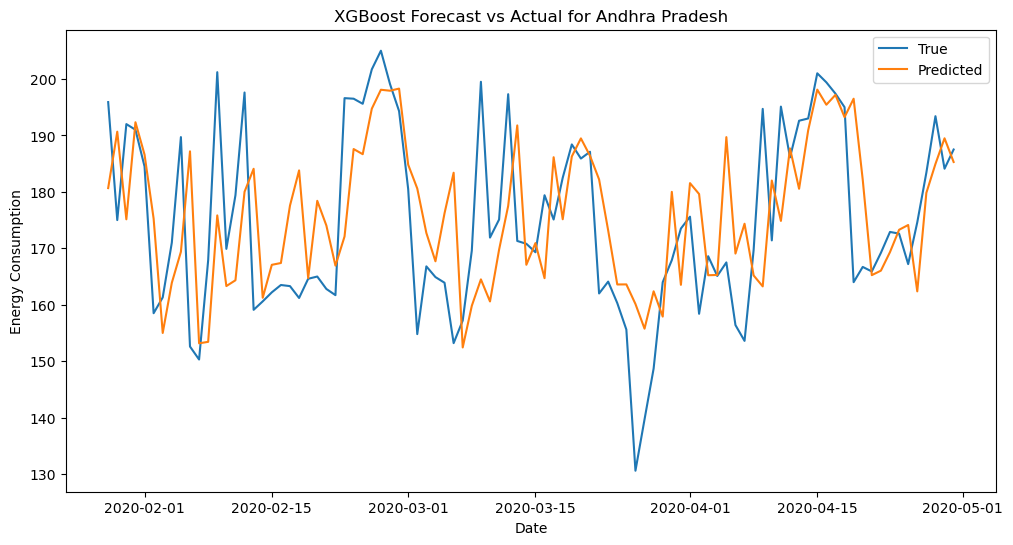

In [17]:
# Parameters
n_lags = 7  # number of past days used as features
train_ratio = 0.8

metrics_all_states = {}

for state in df_wide.columns:
    # Create lag features for the state
    df_lags = create_lag_features(df_wide[state], n_lags)
    
    # Split into train and test
    train_size = int(len(df_lags) * train_ratio)
    train = df_lags.iloc[:train_size]
    test = df_lags.iloc[train_size:]
    
    X_train = train.drop(state, axis=1)
    y_train = train[state]
    X_test = test.drop(state, axis=1)
    y_test = test[state]
    
    # Initialize and train XGBoost Regressor
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics_all_states[state] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    # Plot predictions vs true values for first state only (optional)
    if state == df_wide.columns[0]:
        plt.figure(figsize=(12,6))
        plt.plot(y_test.index, y_test, label='True')
        plt.plot(y_test.index, y_pred, label='Predicted')
        plt.title(f'XGBoost Forecast vs Actual for {state}')
        plt.xlabel('Date')
        plt.ylabel('Energy Consumption')
        plt.legend()
        plt.show()


In [21]:
# Summary of metrics for all states
xgboost_metrics_df = pd.DataFrame(metrics_all_states).T
print(xgboost_metrics_df)


                        RMSE        MAE        R2
Andhra Pradesh     13.988047  10.788229  0.232645
Arunachal Pradesh   0.278084   0.198941 -0.416298
Assam               4.781517   3.500719 -0.165222
Bihar              16.646946  12.469595 -0.233624
Chandigarh          1.288648   0.977374  0.024379
Chhattisgarh        9.081502   6.997170 -0.022342
DNH                 5.167007   2.910625 -0.296009
Delhi              27.098209  19.534353  0.137827
Goa                 1.956778   1.371637 -0.515491
Gujarat            39.407692  28.651389  0.011752
HP                  4.776818   3.315920 -0.041658
Haryana            42.488259  31.450867  0.038561
J&K                 6.102763   4.334827 -0.180222
Jharkhand           1.844711   1.472775  0.032604
Karnataka          30.023083  21.994632 -0.071742
Kerala              6.581138   5.020616  0.242285
MP                 30.853711  22.750524 -0.028381
Maharashtra        40.206187  30.667559  0.119576
Manipur             0.228771   0.182740 -0.299403


In [23]:
xgboost_metrics_df.to_csv("xgboost_metrics_summary.csv", index=True)